Project : CamemBERT  
Unit : Advanced Machine Learning   
MSc. Intelligent systems engineering  
SORBONNE UNIVERSITÉ  

--- Students ---  
@SSivanesan - Shivamshan SIVANESAN  
@Emirtas7 - Emir TAS  
@KishanthanKingston - Kishanthan KINGSTON 


# Pos-tagging evaluation with RoBERTa pretrained version retrained with our French database

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, RobertaForTokenClassification, AdamW, RobertaConfig
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from PosTagging import PosTaggingDataset, CollateFn, ConlluReader

In [2]:
label_mapping = {"ADJ": 0, "ADP": 1, "ADV": 2, "AUX": 3, "CCONJ": 4, "DET": 5,
                 "INTJ": 6, "NOUN": 7, "NUM": 8, "PRON": 9, "PROPN": 10, "PUNCT": 11,
                 "SCONJ": 12, "SYM": 13, "VERB": 14, "X": 15, '<UNK>': 16}

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Load and split the data
file_path_conllu = 'Evaluation_dataset/UD_French-GSD/fr_gsd-ud-train.conllu'

read_conllu = ConlluReader(file_path_conllu)

all_data = read_conllu.read_file()

train_data, val_data = train_test_split(all_data, test_size=0.1, random_state=42)

# Create datasets and dataloaders
batch_size = 512
train_dataset = PosTaggingDataset(train_data, tokenizer, label_mapping)
val_dataset = PosTaggingDataset(val_data, tokenizer, label_mapping)

collate_fn = CollateFn(tokenizer, label_mapping)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

config = RobertaConfig.from_pretrained("./roberta-retrained", num_labels=len(label_mapping))
config.hidden_dropout_prob = 0.5
model = RobertaForTokenClassification.from_pretrained("./roberta-retrained", config=config)

# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.001)
# Fine-tune the model
model.train()
losses, accuracies = [], []
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    total_loss = 0.0  # Initializer la perte totale pour l'époque
    num_batches = len(train_dataloader)

    for batch_num, batch in enumerate(train_dataloader, 1):
        inputs = {
            'input_ids': batch['input_ids'],
            'attention_mask': batch['attention_mask'],
            'labels': batch['labels']
        }
        
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        losses.append(loss)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Ajouter la perte de ce batch à la perte totale

        # Afficher la perte de chaque batch
        print(f'Epoch {epoch + 1}/{num_epochs}, Batch {batch_num}/{num_batches}, Loss: {loss.item():.4f}')

    average_loss = total_loss / num_batches
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss:.4f}')

model.eval()
total_accuracy = 0

with torch.no_grad():
    for batch in val_dataloader:
        inputs = {
            'input_ids': batch['input_ids'],
            'attention_mask': batch['attention_mask'],
            'labels': batch['labels']
        }
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        # Flatten the labels
        labels_flat = batch['labels'].flatten()
        predictions_flat = predictions.flatten()
        
        accuracy = accuracy_score(labels_flat, predictions_flat)
        accuracies.append(accuracy)
        total_accuracy += accuracy

final_accuracy = total_accuracy / len(val_dataloader)
print(f"Final Accuracy on Validation Set: {final_accuracy}")

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at ./roberta-retrained and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1, Batch 1/26, Loss: 2.9393
Epoch 1/1, Batch 2/26, Loss: 0.3846
Epoch 1/1, Batch 3/26, Loss: 0.8149
Epoch 1/1, Batch 4/26, Loss: 0.0026
Epoch 1/1, Batch 5/26, Loss: 0.2310
Epoch 1/1, Batch 6/26, Loss: 1.8189
Epoch 1/1, Batch 7/26, Loss: 0.0006
Epoch 1/1, Batch 8/26, Loss: 0.0006
Epoch 1/1, Batch 9/26, Loss: 0.0006
Epoch 1/1, Batch 10/26, Loss: 0.0006
Epoch 1/1, Batch 11/26, Loss: 0.0010
Epoch 1/1, Batch 12/26, Loss: 0.0026
Epoch 1/1, Batch 13/26, Loss: 0.0005
Epoch 1/1, Batch 14/26, Loss: 0.0004
Epoch 1/1, Batch 15/26, Loss: 0.0004
Epoch 1/1, Batch 16/26, Loss: 0.0004
Epoch 1/1, Batch 17/26, Loss: 0.0003
Epoch 1/1, Batch 18/26, Loss: 0.0003
Epoch 1/1, Batch 19/26, Loss: 0.0003
Epoch 1/1, Batch 20/26, Loss: 0.0003
Epoch 1/1, Batch 21/26, Loss: 0.0003
Epoch 1/1, Batch 22/26, Loss: 0.0003
Epoch 1/1, Batch 23/26, Loss: 0.0003
Epoch 1/1, Batch 24/26, Loss: 0.0003
Epoch 1/1, Batch 25/26, Loss: 0.0003
Epoch 1/1, Batch 26/26, Loss: 0.0002
Epoch 1/1, Average Loss: 0.2385
Final Accuracy 

26 3


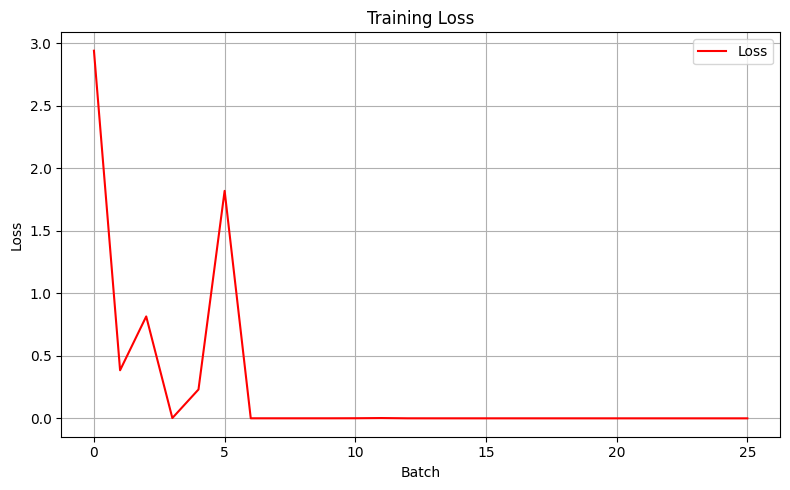

In [13]:
import matplotlib.pyplot as plt

losses_values = [loss.item() for loss in losses]
print(len(losses_values), len(accuracies))

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(losses_values, 'r', label='Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Batch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()